## Model Comparison

Here we compare the performance of the final model on the test set. We evaluate different metrics and compare the ROC curve. For that we have to use the same random seeds as for training so that we get the same test set.

In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch_geometric
import random
from torch_geometric.loader import DataLoader, ImbalancedSampler
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, roc_curve,
    precision_recall_curve, balanced_accuracy_score
)
from dataset import Tox21Dataset, random_split_dataset
from trainer import Trainer
import os

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
rnd_seed=1

random.seed(rnd_seed)
np.random.seed(rnd_seed)
torch.manual_seed(rnd_seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(rnd_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark     = False

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() + worker_id
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(rnd_seed)

### Load Data and Models

Load test data

In [4]:
root_dir = os.path.join(os.getcwd(),'data_1')
ds = Tox21Dataset(root=root_dir, task=['NR-AhR'])
_ , _ , test_set = random_split_dataset(ds, frac_train=0.9, frac_val=0.0, frac_test=0.1)

batch_size = 64
test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=True, drop_last=True, worker_init_fn=seed_worker,generator=g)


/opt/homebrew/anaconda3/lib/python3.13/site-packages/torch_geometric/io/fs.py:229: UserWarning: Weights only load failed. Please file an issue to make `torch.load(weights_only=True)` compatible in your case. Please use `torch.serialization.add_safe_globals([rdkit.Chem.rdchem.Mol])` to allowlist this global.
  warnings.warn(f"{warn_msg} Please use "


Load models

In [5]:
from models import simpleGAT, simpleGIN, MPNNModel

In [6]:
GATmodel = simpleGAT(in_channels=test_set[0].x.size(1), dim_h=64, out_channels=test_set[0].y.size(0), num_layers=4, heads=4, dropout=0.4).to(device)

GATtrainer = Trainer(model=GATmodel,
                  train_loader=None,
                  val_loader=None,
                  test_loader=test_dataloader,
                  device=device,
                  save_dir=os.path.join(os.getcwd(),'models/final'),
                  save_name='GAT')

GATtrainer.load_model()

GINmodel = simpleGIN(in_channels=test_set[0].x.size(1), dim_h=64, out_channels=test_set[0].y.size(0), num_layers=3, dropout=0.2).to(device)

GINtrainer = Trainer(model=GINmodel,
                  train_loader=None,
                  val_loader=None,
                  test_loader=test_dataloader,
                  device=device,
                  save_dir=os.path.join(os.getcwd(),'models/final'),
                  save_name='GIN')

GINtrainer.load_model()

MPNNmodel = MPNNModel(node_dim=test_set[0].x.size(1), edge_dim=test_set[0].edge_attr.size(1), hidden_dim=64, num_layers=2, dropout=0.2).to(device)

MPNNtrainer = Trainer(model=MPNNmodel,
                  train_loader=None,
                  val_loader=None,
                  test_loader=test_dataloader,
                  device=device,
                  save_dir=os.path.join(os.getcwd(),'models/final'),
                  save_name='MPNN')

MPNNtrainer.load_model()



## Compare performance

In [9]:
print('GAT Model')
GATtest_loss, GATtest_acc, GATtest_auc , GATtest_bal_acc, GATpreds, GATpred_probs, GATlabels = GATtrainer.test()
print('GIN Model')
GINtest_loss, GINtest_acc, GINtest_auc , GINtest_bal_acc, GINpreds, GINpred_probs, GINlabels = GINtrainer.test()
print('MPNN Model')
MPNNtest_loss, MPNNtest_acc, MPNNtest_auc , MPNNtest_bal_acc, MPNNpreds, MPNNpred_probs, MPNNlabels = MPNNtrainer.test()

GAT Model
Test loss: 0.2766, test acc 0.8953, test_auc 0.8873, test_bal_acc 0.7431
GIN Model
Test loss: 0.3421, test acc 0.8922, test_auc 0.8686, test_bal_acc 0.7245
MPNN Model
Test loss: 0.2839, test acc 0.8719, test_auc 0.8796, test_bal_acc 0.7321


Show the confusion matrix

Text(0.5, 1.0, 'MPNN Confusion Matrix')

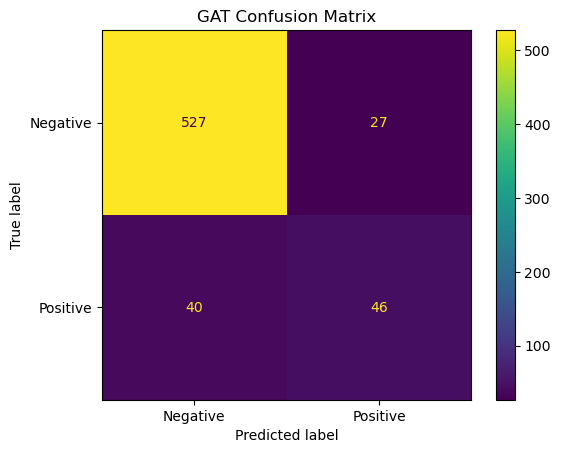

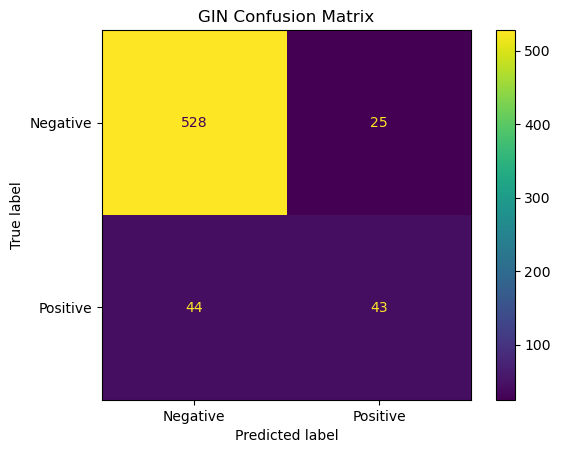

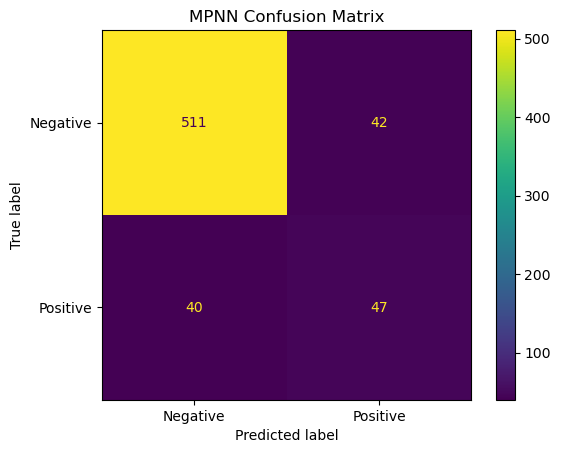

In [12]:
c_matrixGAT = confusion_matrix(GATlabels.numpy(), GATpreds)
disp = ConfusionMatrixDisplay(
    c_matrixGAT, display_labels=["Negative","Positive"]
)
disp.plot() 
plt.title("GAT Confusion Matrix") 
c_matrixGIN = confusion_matrix(GINlabels.numpy(), GINpreds)
disp = ConfusionMatrixDisplay(
    c_matrixGIN, display_labels=["Negative","Positive"]
)
disp.plot() 
plt.title("GIN Confusion Matrix") 
c_matrixMPNN = confusion_matrix(MPNNlabels.numpy(), MPNNpreds)
disp = ConfusionMatrixDisplay(
    c_matrixMPNN, display_labels=["Negative","Positive"]
)
disp.plot() 
plt.title("MPNN Confusion Matrix") 

ROC cuves

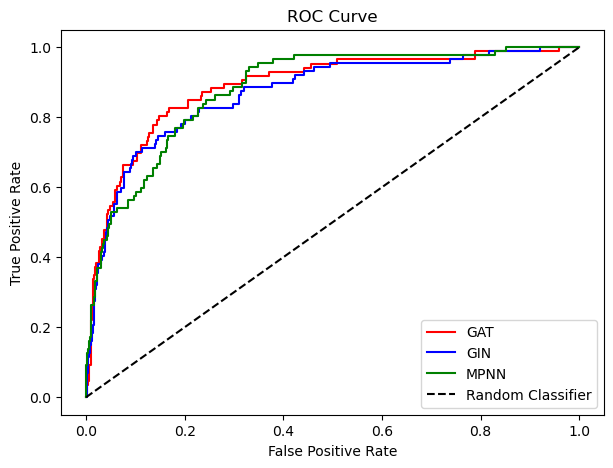

In [15]:
from sklearn.preprocessing import label_binarize

GATy_true_bin = label_binarize(GATlabels.numpy(), classes=np.arange(2))
GATfpr, GATtpr, _ = roc_curve(GATy_true_bin[:, 0], GATpred_probs.numpy())
GINy_true_bin = label_binarize(GINlabels.numpy(), classes=np.arange(2))
GINfpr, GINtpr, _ = roc_curve(GINy_true_bin[:, 0], GINpred_probs.numpy())
MPNNy_true_bin = label_binarize(MPNNlabels.numpy(), classes=np.arange(2))
MPNNfpr, MPNNtpr, _ = roc_curve(MPNNy_true_bin[:, 0], MPNNpred_probs.numpy())

plt.figure(figsize=(7,5))
plt.plot(GATfpr, GATtpr, "r-", label="GAT")
plt.plot(GINfpr, GINtpr, "b-", label="GIN")
plt.plot(MPNNfpr, MPNNtpr, "g-", label="MPNN")
plt.plot([0,1], [0,1], "k--", label="Random Classifier")
plt.xlabel("False Positive Rate") 
plt.ylabel("True Positive Rate")
plt.title("ROC Curve") 
plt.legend() 
plt.savefig('ROC.pdf')
plt.show()

## Conclusion

All models perfomr almost equally well and all of them have a large false-negative rate. Interestingly the MPNN network also has a significantly larger false-positive rate than most other models. This suggests that the class-imbalance was not a large holdback in the training process.

The above ROC curve also shows that all models have a similar performance with a slight advantage for the GAT architecture. The GAT architecture is also the one which responded well to explainability algorithms. This seems to suggest that the GAT model managed to identify good features.